## Assignment 7

The goal of this lab is to introduce the basic models used to simulate epidemics in networks, experiment with them and compare them. 
We will explore both types of diffusion models, decision-based and epidemic ones.
As a use case, we are going to use the coauthorship network of network scientists, which you can load with the function read gml from networkx library.

The following questions can be answered with the help of networkx and NDlib. You may also use other packages to deal with the problem. Please answer the following
questions on the networks you have and submit your executable code.

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random


In [2]:
#path = ""


In [6]:
# download a file from a url 
import requests

def download(url,file_name):
    get_response = requests.get(url)
    with open(file_name, "wb") as out_file:
        out_file.write(get_response.content)

#download(url = "http://www.casos.cs.cmu.edu/computational_tools/datasets/external/netscience/netscience.gml", file_name=path+"netscience.gml")
download(url = "http://www.casos.cs.cmu.edu/computational_tools/datasets/external/netscience/netscience.gml", file_name="netscience.gml")

In [24]:
# Read the data and show the basic information

file_name = "netscience.gml"
graph = nx.read_gml(file_name)

# Show basic information about the graph
print(nx.info(graph))

print("Nodes:", list(graph.nodes)[:10])  # Display first 10 nodes
print("Edges:", list(graph.edges)[:10])  # Display first 10 edges

Graph with 1589 nodes and 2742 edges
Nodes: ['ABRAMSON, G', 'KUPERMAN, M', 'ACEBRON, J', 'BONILLA, L', 'PEREZVICENTE, C', 'RITORT, F', 'SPIGLER, R', 'ADAMIC, L', 'ADAR, E', 'HUBERMAN, B']
Edges: [('ABRAMSON, G', 'KUPERMAN, M'), ('ABRAMSON, G', 'MORELLI, L'), ('KUPERMAN, M', 'ZANETTE, D'), ('KUPERMAN, M', 'MORELLI, L'), ('ACEBRON, J', 'BONILLA, L'), ('ACEBRON, J', 'PEREZVICENTE, C'), ('ACEBRON, J', 'RITORT, F'), ('ACEBRON, J', 'SPIGLER, R'), ('BONILLA, L', 'PEREZVICENTE, C'), ('BONILLA, L', 'RITORT, F')]


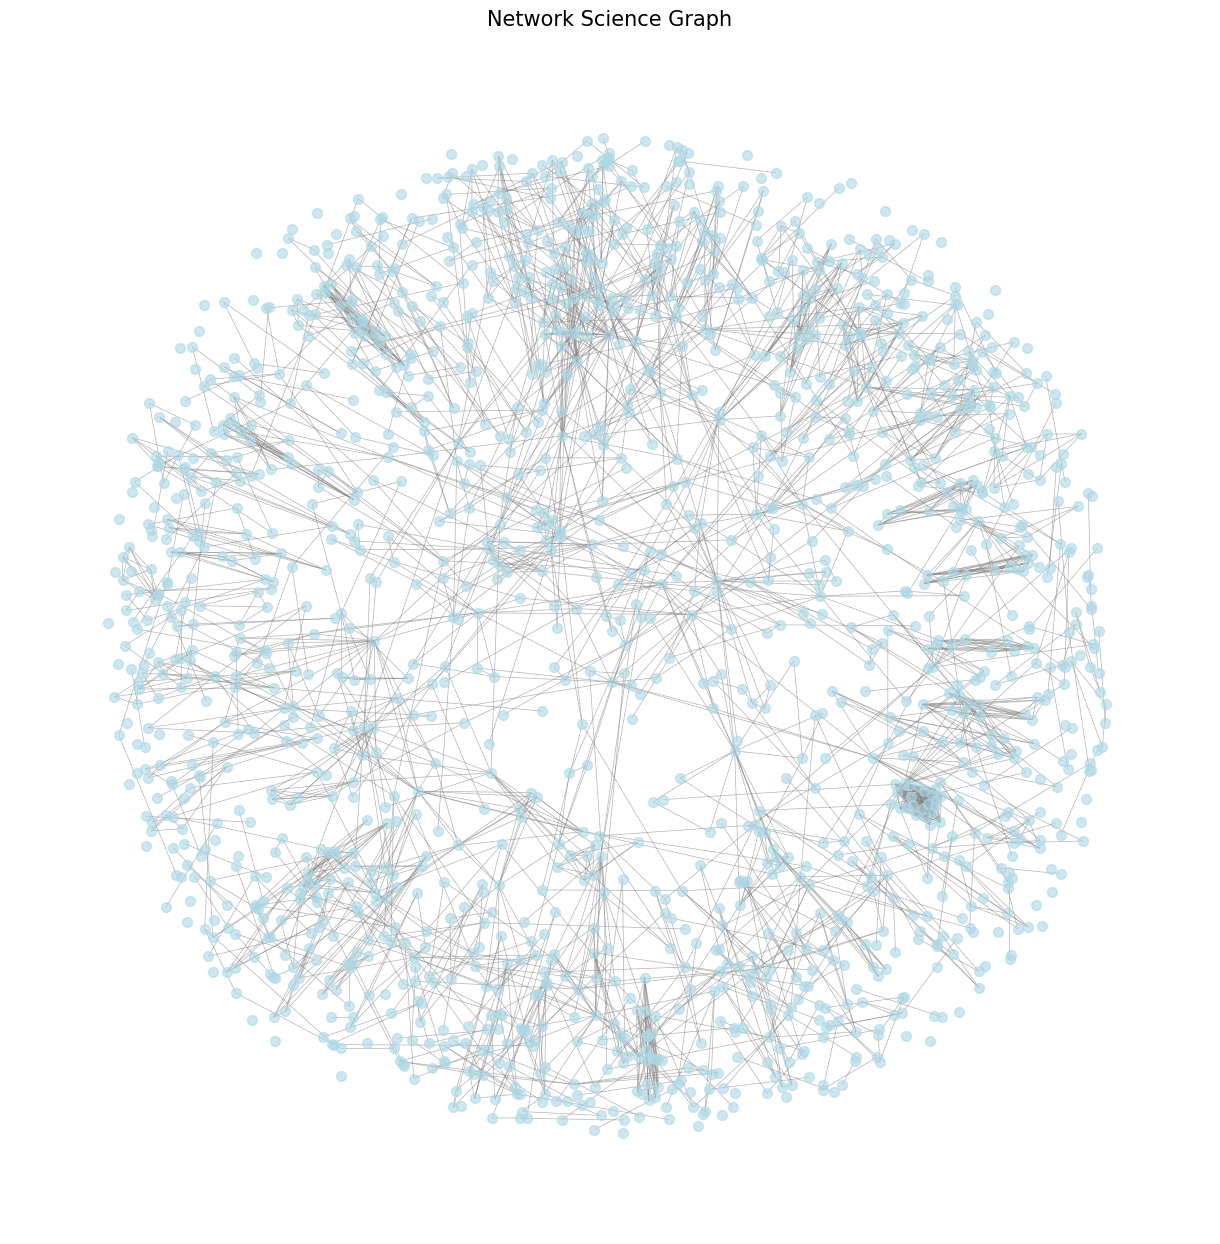

In [4]:
plt.figure(figsize=(12, 12))  

pos = nx.spring_layout(graph, seed=42, k=0.15) 

nx.draw(graph, pos, with_labels=False, node_size=50, font_size=10, font_color='black', 
        edge_color='gray', alpha=0.6, width=0.5, node_color='lightblue')

plt.title("Network Science Graph", fontsize=15)
plt.show()

**(a)** The Sznajd model is a variant of spin model based on social impact, which
takes into account the fact that a group of individuals with the same opinion can influence their
neighbours more than one single individual. Please use the Sznajd model to simulate the cascade
of misinformation between the network of network scientists for 100 steps with different initial ”infected” numbers: 100, 300, and 700. Please visualize the results and output a prevalence plot. (May refer to NDlib.)

In [25]:
def plot_diffusion_trend_and_prevalence(trends, num_iterations, total_nodes):
    # Initialize lists to track the number and fraction of nodes with each opinion
    pos_count_over_time = []
    neg_count_over_time = []
    
    for trend in trends:
        # Extract counts from each iteration's trend data
        pos_count = trend['trends']['node_count'][0]
        neg_count = trend['trends']['node_count'][1]

        # Append counts to track the evolution of opinions
        pos_count_over_time.append(pos_count)
        neg_count_over_time.append(neg_count)

    # Store fractions (for prevalence)
    pos_opinion_prevalence = [i / total_nodes for i in pos_count_over_time]
    neg_opinion_prevalence = [i / total_nodes for i in neg_count_over_time]

    # Create a figure with two subplots: one for Trend and one for Prevalence
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Diffusion Trend (absolute pos_count)
    ax1.plot(range(num_iterations), pos_count_over_time, label="Positive Opinion (+1)", color='blue')
    ax1.plot(range(num_iterations), neg_count_over_time, label="Negative Opinion (-1)", color='red')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Number of Nodes')
    ax1.set_title('Diffusion Trend: Opinion Dynamics')
    ax1.legend()

    # Plot Diffusion Prevalence (fractions)
    ax2.plot(range(num_iterations), pos_opinion_prevalence, label="Positive Opinion (+1)", color='blue')
    ax2.plot(range(num_iterations), neg_opinion_prevalence, label="Negative Opinion (-1)", color='red')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Prevalence (Fraction of Nodes)')
    ax2.set_title('Diffusion Prevalence: Opinion Dynamics')
    ax2.legend()

    # Show the combined plot
    plt.tight_layout()
    plt.show()


In [30]:
def sznajd_model(G, initial_infected_number, number_iterations):
    """
    Simulate the Sznajd model on the given graph and plot the diffusion trends.
    
    Args:
        G: networkx graph
        initial_infected_number: Initial number of infected (nodes with positive opinion)
        number_iterations: Number of iterations for the simulation
        
    Returns:
        trends: A list of dictionaries tracking the number of nodes with each opinion at each iteration
    """

    for node in G.nodes():
        G.nodes[node]['opinion'] = -1  # Initially, all nodes have negative opinion

    initial_infected_nodes = random.sample(G.nodes(), initial_infected_number)
    for node in initial_infected_nodes:
        G.nodes[node]['opinion'] = 1  # Setting the opinion of selected nodes to +1 (infected)

    trends = []

    # Simulation over the specified number of iterations
    for iteration in range(number_iterations):
        # Storing the current trend: count of positive and negative opinions
        pos_count = sum(1 for node in G.nodes() if G.nodes[node]['opinion'] == 1)
        neg_count = len(G.nodes()) - pos_count

        trends.append({
            'iteration': iteration,
            'trends': {
                'node_count': [pos_count, neg_count]
            }
        })

        # Applying the Sznajd model update rules by iterating over nodes
        nodes = list(G.nodes())

        # Iterate over all pairs of nodes in sequential order
        for i in range(0, len(nodes) - 1, 2):  # Process pairs (i, i+1)
            node_a = nodes[i]
            node_b = nodes[i + 1]

            opinion_a = G.nodes[node_a]['opinion']
            opinion_b = G.nodes[node_b]['opinion']

            # If both neighbors have the same opinion, they will influence their neighbors
            if opinion_a == opinion_b:
                # Get neighbors of both nodes
                neighbors_a = list(G.neighbors(node_a))
                neighbors_b = list(G.neighbors(node_b))

                # Update the opinion of neighbors to match if their opinion is different
                for neighbor in neighbors_a + neighbors_b:
                    if G.nodes[neighbor]['opinion'] != opinion_a:
                        G.nodes[neighbor]['opinion'] = opinion_a

    # Call the plot function to visualize the trend after the simulation
    plot_diffusion_trend_and_prevalence(trends, number_iterations, G.number_of_nodes())


C:\Users\35262\AppData\Local\Temp\ipykernel_29900\1997893550.py:17: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected_nodes = random.sample(G.nodes(), initial_infected_number)


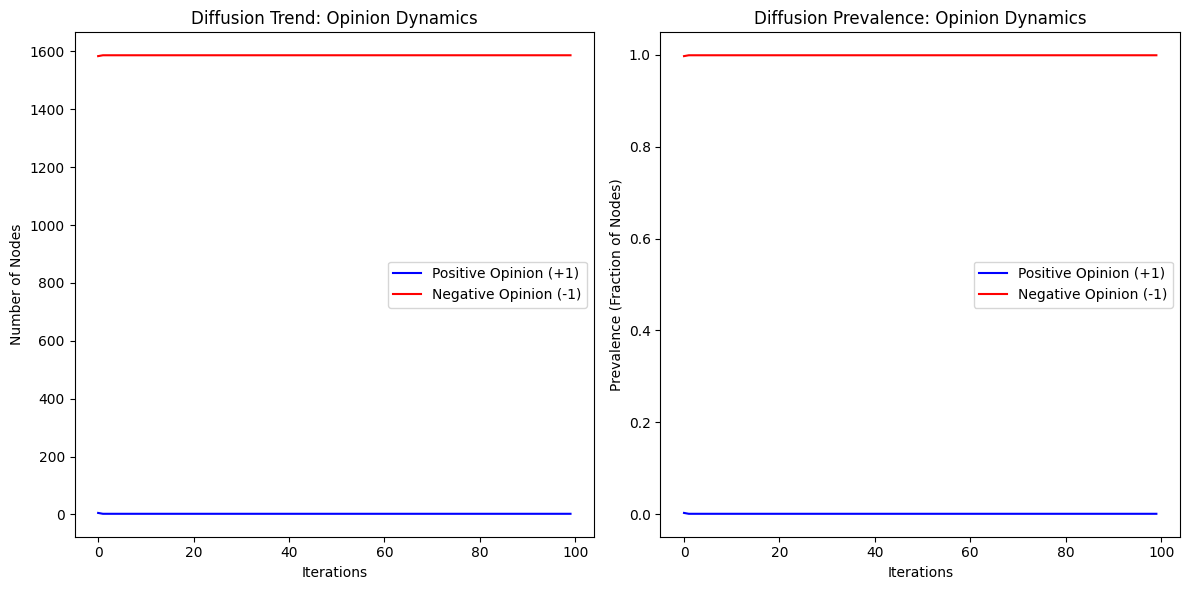

In [32]:
# Run sznajd for initial infected number: 5
sznajd_model(graph, initial_infected_number=5, number_iterations=100)

C:\Users\35262\AppData\Local\Temp\ipykernel_29900\1997893550.py:17: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected_nodes = random.sample(G.nodes(), initial_infected_number)


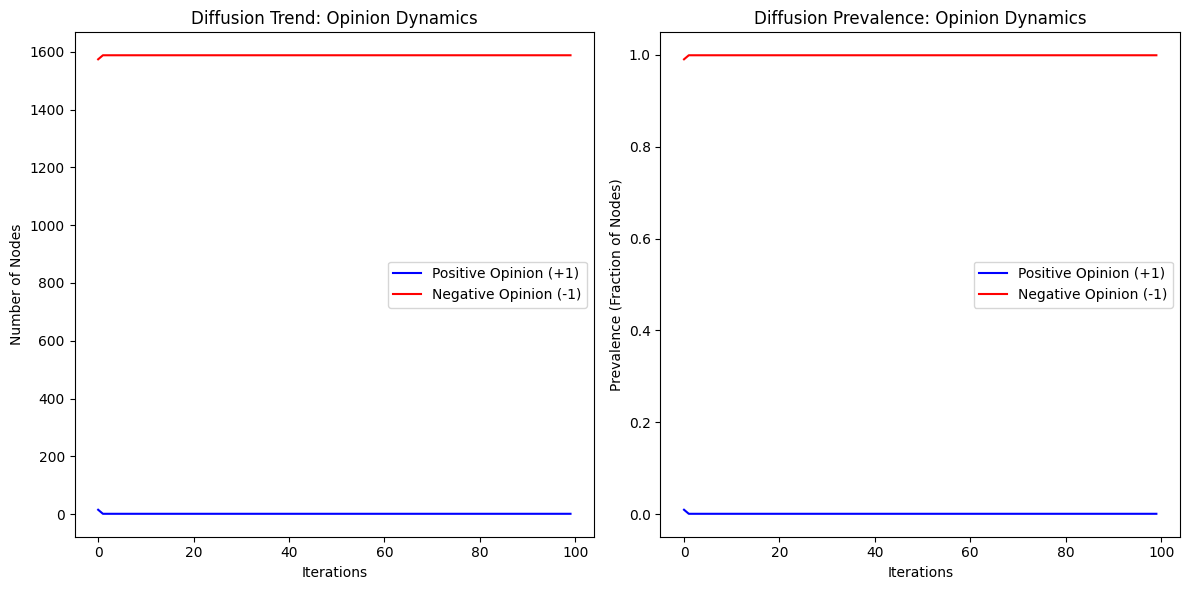

In [33]:
# Run sznajd for initial infected number: 15
sznajd_model(graph, initial_infected_number=15, number_iterations=100)

C:\Users\35262\AppData\Local\Temp\ipykernel_29900\1997893550.py:17: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected_nodes = random.sample(G.nodes(), initial_infected_number)


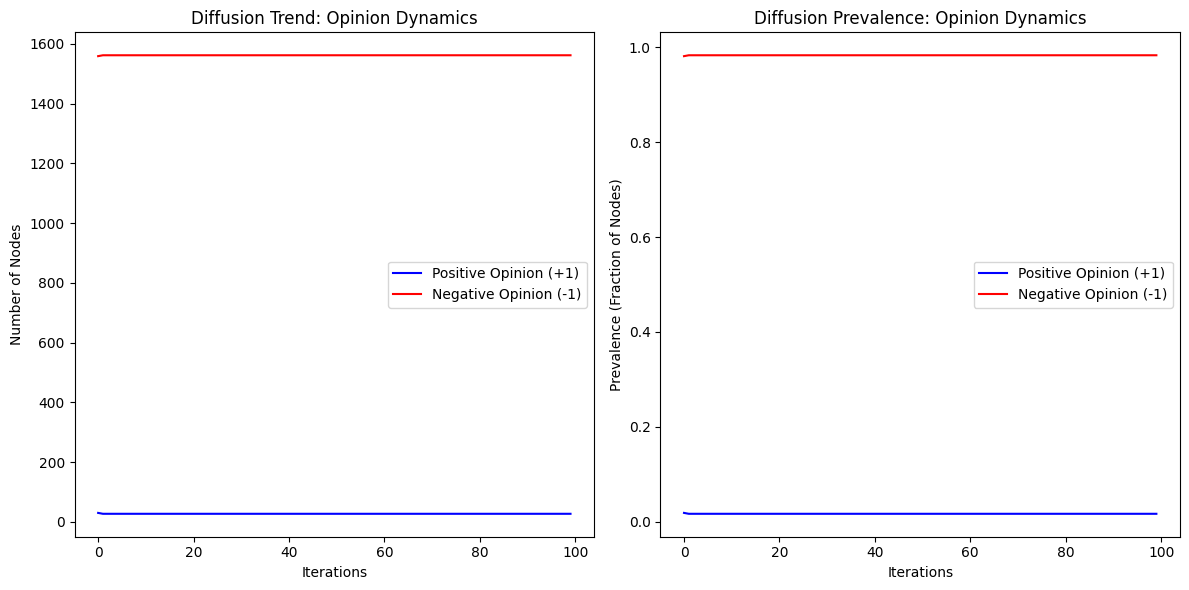

In [34]:
# Run sznajd for initial infected number: 30
sznajd_model(graph, initial_infected_number=30, number_iterations=100)

C:\Users\35262\AppData\Local\Temp\ipykernel_29900\1997893550.py:17: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected_nodes = random.sample(G.nodes(), initial_infected_number)


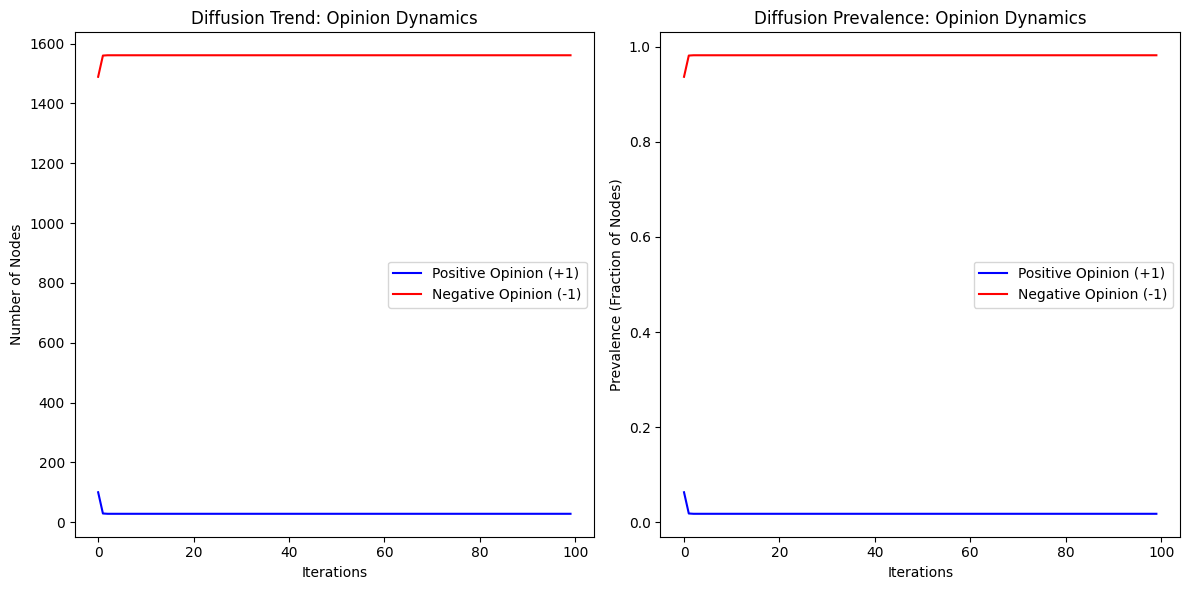

In [35]:
sznajd_model(graph, initial_infected_number=100, number_iterations=100)

C:\Users\35262\AppData\Local\Temp\ipykernel_29900\1997893550.py:17: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected_nodes = random.sample(G.nodes(), initial_infected_number)


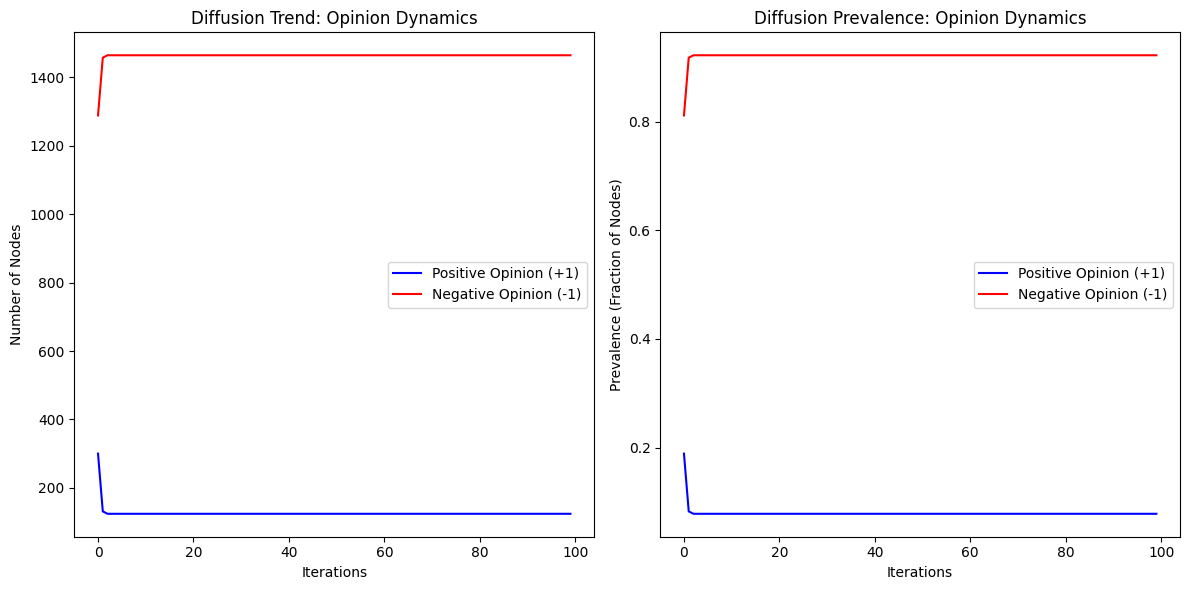

In [36]:
sznajd_model(graph, initial_infected_number=300, number_iterations=100)

C:\Users\35262\AppData\Local\Temp\ipykernel_29900\1997893550.py:17: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected_nodes = random.sample(G.nodes(), initial_infected_number)


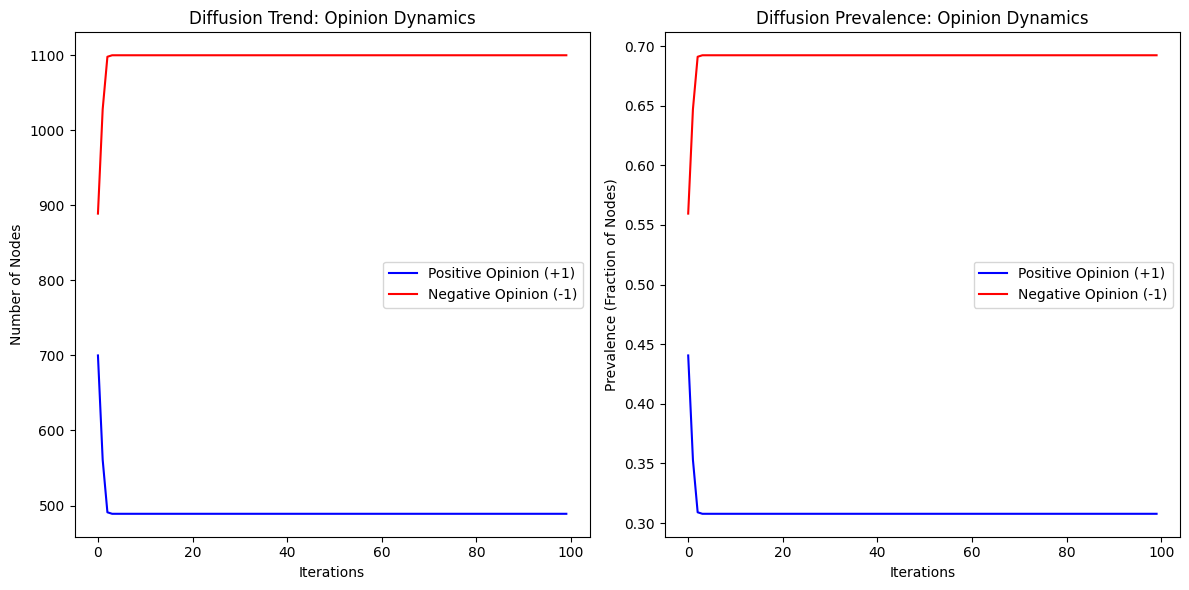

In [37]:
sznajd_model(graph, initial_infected_number=700, number_iterations=100)

**(b)** Although the interaction networks in real-life are different from the social networks we have, it is still meaningful to simulate the epidemics cascade with our dataset. The SIR model was introduced in 1927 by Kermack. In this model, during the course of an epidemic, a node is allowed to change its status from Susceptible (S) to Infected (I), then to Removed (R). Please use the SIR model to simulate for 100 iterations the cascade of the epidemic with the same number of initially infected nodes (suggested 0.5), with the following three sets of infection/removal probabilities: (0.5, 0.2), (0.3, 0.3), (0.4, 0.5) on the network science dataset, and visualize the results.

In [16]:
def SIR_model(G, ini_infect, infection, removal, num_iterations):
    """
    Args:
        G: networkx graph
        ini_infect (float): initial fraction of infected nodes
        infection (float): initial set of infected nodes
        removal (float): removal probability
        num_iterations (int): number of iterations
    """
    # declare the model
   

    # Configuration of the model
    
    # Simulation execution
   
    %matplotlib inline
    # visualize the result
   

    %matplotlib inline
    # prevalence plot
    

    return

In [38]:
print("Running SIR model simulation for {0} infection probability and {1} removal probability.".format(0.5, 0.2))


Running SIR model simulation for 0.5 infection probability and 0.2 removal probability.


In [ ]:
print("Running SIR model simulation for {0} infection probability and {1} removal probability.".format(0.3, 0.3))

In [ ]:
print("Running SIR model simulation for {0} infection probability and {1} removal probability.".format(0.4, 0.5))

In [ ]:
print("Running SIR model simulation for {0} infection probability and {1} removal probability.".format(0.4, 0.5))